Loading the modules.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from keras.optimizers import AdamW

Loading and splitting the data.

In [ ]:
(train_set, valid_set, test_set), (data_info)  = tfds.load(
    name="uc_merced",
    split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
    as_supervised=True,
    shuffle_files = True,
    with_info = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/uc_merced/2.0.0.incompletePC389O/uc_merced-train.tfrecord*...:   0%|      …

Dataset uc_merced downloaded and prepared to /root/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
valid_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Checking the sizes of each dataset.

In [ ]:
print(train_set.cardinality().numpy())

1470


In [ ]:
print(valid_set.cardinality().numpy())

315


In [ ]:
print(test_set.cardinality().numpy())

315


We see, that there are 21 classes.

In [ ]:
data_info

tfds.core.DatasetInfo(
    name='uc_merced',
    full_name='uc_merced/2.0.0',
    description="""
    UC Merced is a 21 class land use remote sensing image dataset, with 100 images
    per class. The images were manually extracted from large images from the USGS
    National Map Urban Area Imagery collection for various urban areas around the
    country. The pixel resolution of this public domain imagery is 0.3 m.
    
    While most images are 256x256 pixels, there are 44 images with different shape.
    """,
    homepage='http://weegee.vision.ucmerced.edu/datasets/landuse.html',
    data_dir=PosixGPath('/tmp/tmpmmd01ek5tfds'),
    file_format=tfrecord,
    download_size=317.07 MiB,
    dataset_size=238.63 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=21),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=F

Getting examples of images.

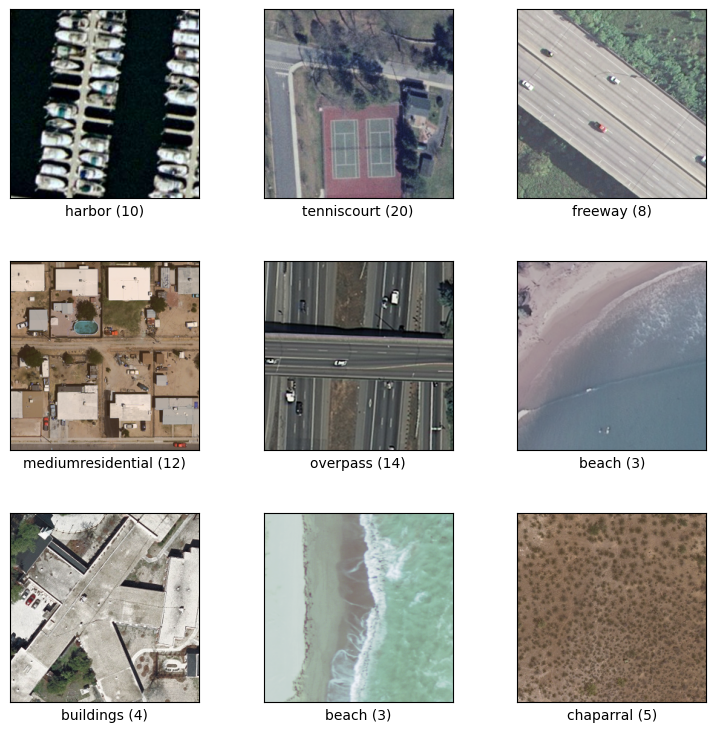

In [ ]:
fig = tfds.show_examples(train_set, tfds.builder('uc_merced').info)

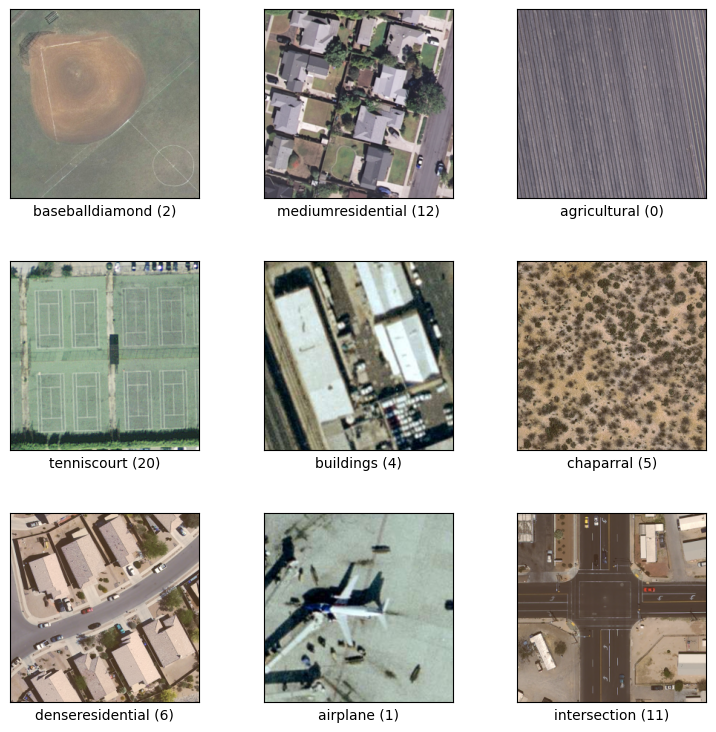

In [ ]:
fig2 = tfds.show_examples(valid_set, tfds.builder('uc_merced').info)

Preparing images for neural network.

In [ ]:
image_size = (256, 256)
def normalize(image, label):
    normalized_image = tf.image.resize(image, image_size)
    normalized_image /= 255
#    normalized_image = tf.cast(normalized_image, tf.float16)
    return normalized_image, label

In [ ]:
train_set = train_set.shuffle(7_000, seed=42).map(normalize).batch(32, drop_remainder=True).prefetch(1)
valid_set = valid_set.map(normalize).batch(32, drop_remainder=True).cache().prefetch(1)
test_set = test_set.map(normalize).batch(32, drop_remainder=True).cache().prefetch(1)
tf.random.set_seed(42)

Building the network.

In [ ]:
tf.random.set_seed(42)
model = Sequential()
model.add(Conv2D(input_shape=(256, 256, 3), filters=32,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256,activation='relu',
                 kernel_size=(3,3),padding='same'
                 ))
model.add(tf.keras.layers.GlobalAvgPool2D())
# model.add(Flatten())
model.add(tf.keras.layers.Dropout(0.5)),
# model.add(Dense(256, activation='relu')),
# model.add(tf.keras.layers.Dropout(0.8)),
# model.add(Dense(128, activation='relu')),
# model.add(tf.keras.layers.Dropout(0.5)),
model.add(Dense(21, activation='softmax'))

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=25,
                                                     restore_best_weights=True)

In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

Compiling the network.

In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 32, 128)      

Training and evaluating our network.

In [ ]:
history = model.fit(train_set, epochs=250,
                    validation_data=(valid_set), callbacks=[checkpoint_cb, early_stopping_cb])
score = model.evaluate(test_set)

Epoch 1/250
45/45 [==============================] - 13s 88ms/step - loss: 3.0224 - accuracy: 0.0396 - val_loss: 2.9592 - val_accuracy: 0.0312
Epoch 2/250
45/45 [==============================] - 5s 66ms/step - loss: 2.8847 - accuracy: 0.1139 - val_loss: 2.8061 - val_accuracy: 0.1146
Epoch 3/250
45/45 [==============================] - 6s 68ms/step - loss: 2.7025 - accuracy: 0.1632 - val_loss: 2.5491 - val_accuracy: 0.1910
Epoch 4/250
45/45 [==============================] - 5s 67ms/step - loss: 2.5110 - accuracy: 0.2056 - val_loss: 2.3242 - val_accuracy: 0.2500
Epoch 5/250
45/45 [==============================] - 5s 66ms/step - loss: 2.4091 - accuracy: 0.2139 - val_loss: 2.3442 - val_accuracy: 0.3056
Epoch 6/250
45/45 [==============================] - 5s 67ms/step - loss: 2.2777 - accuracy: 0.2368 - val_loss: 2.1729 - val_accuracy: 0.2951
Epoch 7/250
45/45 [==============================] - 6s 76ms/step - loss: 2.2141 - accuracy: 0.2799 - val_loss: 2.1577 - val_accuracy: 0.3438
Epoch

In [ ]:
# score = model.evaluate(test_set)

Visualizing the training process.

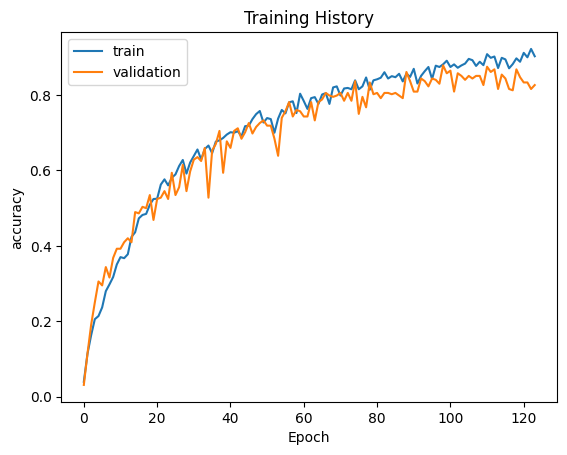

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title('Training History'),
plt.xlabel('Epoch'),
plt.ylabel('accuracy')
plt.show()

Saving the model.

In [ ]:
model.save('uc_merced_model.keras')

In [ ]:
# new_model = tf.keras.models.load_model('uc_merced_model.keras')